In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
from scipy.special import kv
from scipy.sparse import linalg, csc_matrix

import matplotlib.pyplot as plt
font = {'size'   : 16}
plt.rc('font', **font)

In [2]:
# Stehfest's inversion method

def Vfunction(i, N):
    sum1 = 0.
    kmin = int(math.floor((i + 1.) / 2.))
    kmax = min(i, N)
    
    for k in range(kmin, kmax+1):
        sum1 += (1.*(k**N) * math.factorial(2 * k) / (math.factorial(N - k) * math.factorial(k) * math.factorial(k - 1) * math.factorial(i - k) * math.factorial(2 * k - i)))
    
    return ((-1.)**(N + i)) * sum1

In [3]:
def rigidity_2D_general(s,x,y,nx,ny,cxx,cyy):
    nCell = nx*ny
    M = np.zeros((nCell,nCell))

    for i in range(1,nx-1):
        for j in range(1,ny-1):
            iCell = i*ny + j

            iW = (i-1)*ny + j
            iE = (i+1)*ny + j
            iS = iCell - 1
            iN = iCell + 1
            iSW = iW - 1
            iNW = iW + 1
            iNE = iE + 1
            iSE = iE - 1

            lx1 = (  (x[i][j+1]-x[i][j-1])/2. + (x[i-1][j+1]-x[i-1][j-1])/2.   ) /2.
            ly1 = (  (y[i][j+1]-y[i][j-1])/2. + (y[i-1][j+1]-y[i-1][j-1])/2.   ) /2.

            lx3 = -(  (x[i][j+1]-x[i][j-1])/2. + (x[i+1][j+1]-x[i+1][j-1])/2.   ) /2.
            ly3 = -(  (y[i][j+1]-y[i][j-1])/2. + (y[i+1][j+1]-y[i+1][j-1])/2.   ) /2.

            lx2 = (  (x[i+1][j]-x[i-1][j])/2. + (x[i+1][j+1]-x[i-1][j+1])/2.   ) /2.
            ly2 = (  (y[i+1][j]-y[i-1][j])/2. + (y[i+1][j+1]-y[i-1][j+1])/2.   ) /2.

            lx4 = -(  (x[i+1][j]-x[i-1][j])/2. + (x[i+1][j-1]-x[i-1][j-1])/2.   ) /2.
            ly4 = -(  (y[i+1][j]-y[i-1][j])/2. + (y[i+1][j-1]-y[i-1][j-1])/2.   ) /2.


            Ve = (   np.abs(lx1*ly4 - ly1*lx4) + np.abs(lx2*ly3 - ly2*lx3)    ) /2.

            # West side
            dxdxi = x[i][j] - x[i-1][j] 
            dydxi = y[i][j] - y[i-1][j]
            dxdeta = (  x[i][j+1] - x[i][j-1] + x[i-1][j+1] - x[i-1][j-1] )/4.
            dydeta = (  y[i][j+1] - y[i][j-1] + y[i-1][j+1] - y[i-1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i-1][j]) /2.
            cyy_av = (cyy[i][j] + cyy[i-1][j]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c1xi = -1./Ve * dxidx*(cxy_av*lx1 - cxx_av*ly1) -1./Ve * dxidy*(cyy_av*lx1 - cyx_av*ly1)
            c1eta = -1./Ve * detadx*(cxy_av*lx1 - cxx_av*ly1) -1./Ve * detady*(cyy_av*lx1 - cyx_av*ly1)


            # North side
            dxdeta = x[i][j+1] - x[i][j] 
            dydeta = y[i][j+1] - y[i][j]
            dxdxi = (  x[i+1][j] - x[i-1][j] + x[i+1][j+1] - x[i-1][j+1] )/4.
            dydxi = (  y[i+1][j] - y[i-1][j] + y[i+1][j+1] - y[i-1][j+1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i][j+1]) /2.
            cyy_av = (cyy[i][j] + cyy[i][j+1]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c2xi = -1./Ve * dxidx*(cxy_av*lx2 - cxx_av*ly2) -1./Ve * dxidy*(cyy_av*lx2 - cyx_av*ly2)
            c2eta = -1./Ve * detadx*(cxy_av*lx2 - cxx_av*ly2) -1./Ve * detady*(cyy_av*lx2 - cyx_av*ly2)

            # East side
            dxdxi = x[i+1][j] - x[i][j] 
            dydxi = y[i+1][j] - y[i][j]
            dxdeta = (  x[i][j+1] - x[i][j-1] + x[i+1][j+1] - x[i+1][j-1] )/4.
            dydeta = (  y[i][j+1] - y[i][j-1] + y[i+1][j+1] - y[i+1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i+1][j]) /2.
            cyy_av = (cyy[i][j] + cyy[i+1][j]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c3xi = -1./Ve * dxidx*(cxy_av*lx3 - cxx_av*ly3) -1./Ve * dxidy*(cyy_av*lx3 - cyx_av*ly3)
            c3eta = -1./Ve * detadx*(cxy_av*lx3 - cxx_av*ly3) -1./Ve * detady*(cyy_av*lx3 - cyx_av*ly3)

            # South side
            dxdeta = x[i][j] - x[i][j-1] 
            dydeta = y[i][j] - y[i][j-1]
            dxdxi = (  x[i+1][j] - x[i-1][j] + x[i+1][j-1] - x[i-1][j-1] )/4.
            dydxi = (  y[i+1][j] - y[i-1][j] + y[i+1][j-1] - y[i-1][j-1] )/4.

            detJ = dxdxi*dydeta - dxdeta*dydxi

            dxidx = dydeta/detJ
            dxidy = -dxdeta/detJ
            detadx = -dydxi/detJ
            detady = dxdxi/detJ


            cxx_av = (cxx[i][j] + cxx[i][j-1]) /2.
            cyy_av = (cyy[i][j] + cyy[i][j-1]) /2.
            cxy_av = 0.
            cyx_av = 0.

            c4xi = -1./Ve * dxidx*(cxy_av*lx4 - cxx_av*ly4) -1./Ve * dxidy*(cyy_av*lx4 - cyx_av*ly4)
            c4eta = -1./Ve * detadx*(cxy_av*lx4 - cxx_av*ly4) -1./Ve * detady*(cyy_av*lx4 - cyx_av*ly4)




            M[iCell][iCell] = s + c1xi - c2eta - c3xi + c4eta

            M[iCell][iW] = -(c1xi + c2xi/4. + c4xi/4.)    
            M[iCell][iN] = c2eta + c1eta/4. + c3eta/4.    
            M[iCell][iE] = c3xi + c2xi/4. + c4xi/4.
            M[iCell][iS] = -(c4eta + c1eta/4. + c3eta/4.)

            M[iCell][iSW] = -(c1eta/4. + c4xi/4.)    
            M[iCell][iNW] = c1eta/4. - c2xi/4. 
            M[iCell][iNE] = c2xi/4. + c3eta/4.
            M[iCell][iSE] = -(c3eta/4. - c4xi/4.)

    return M

def BC_pressure_M(M,
                iCell):
    M[iCell,:] = 0
    M[iCell][iCell] = 1 
        

def BC_flowRate_M(M,
               iCell,
               iNeighbor):    
    M[iCell,:] = 0
    M[iCell][iCell] = 1
    M[iCell][iNeighbor] = -1
    
def BC_pressure_f(f,
             iCell,
             pCell):
    f[iCell] = pCell

In [4]:
def solve(matrixR,vectorF):
    # Direct solvers ####################################
    #return np.linalg.solve(matrixR,vectorF)
    #return scipy.linalg.solve(matrixR,vectorF)



    return linalg.spsolve(csc_matrix(matrixR, dtype=float), csc_matrix(vectorF, dtype=float)) # only for nCells <= 100 x 100



    #return scipy.sparse.linalg.splu(matrixR).solve(vectorF)


    # Iterative solvers###################################
    # Minimal residual iterative method (krylov) # can reach to nCells = 400 x 400 or more
    '''
    A = csc_matrix(matrixR, dtype=float)
    A = A + A.T
    vectorU, exitCode = sp.sparse.linalg.minres(A, vectorF,tol=1e-100, maxiter=10000, show=False)
    return vectorU'''

In [5]:
def Laplace_FVM(pIn,
                pOut,
                x, # x coordinate of the cell centers
                y, # y coordinate of the cell centers
                nx, # number of cell in each row
                ny, # number of cell in each column
                cxx, # diffusivity xx
                cyy, # diffusivity yy
                t, # diffusion time
                nStehfest
                ): 
    # Force
    nCell = nx*ny
    f = np.zeros(nCell)
    
    for i in range(1,ny-1):
        BC_pressure_f(f,i,pIn)
        BC_pressure_f(f,nCell-1-i,pOut)
     
    f = f.reshape(len(f),1)
    
    # Solving the linear equation system by the fast Laplace-Stehfest method
    sum_p = np.zeros(nCell)

    for j in range(1,2*nStehfest+1):
        s = j * np.log(2.) / t
        M = rigidity_2D_general(s,x,y,nx,ny,cxx,cyy)

        # Pressure boundary conditions
        for i in range(1,ny-1):
            BC_pressure_M(M,i)
            BC_pressure_M(M,nCell-1-i)
            
        # Lateral impermeability    
        for i in range(0,nx):
            BC_flowRate_M(M,i*ny, i*ny+1)
            BC_flowRate_M(M,(i+1)*ny-1, (i+1)*ny-2)

            
        p = solve(M,f/s)
        sum_p += Vfunction(j,nStehfest) * p

    p = sum_p * np.log(2.) / t
    return p

In [6]:
def implicit_FVM(pIn,
                 pOut,
                 x, # x coordinate of the cell centers
                 y, # y coordinate of the cell centers
                 nx, # number of cell in each row
                 ny, # number of cell in each column
                 cxx, # diffusivity xx
                 cyy, # diffusivity yy
                 t, # diffusion time
                 nTime # Number of time steps
                 ): 
    # Force
    nCell = nx*ny
    f = np.zeros(nCell)
    
    for i in range(1,ny-1):
        BC_pressure_f(f,i,pIn)
        BC_pressure_f(f,nCell-1-i,pOut)
        
    f = f.reshape(len(f),1)
    
    # Solving the linear equation system by using the implicit method
    dt = t/nTime
    for i in range(0,nTime):
        M = rigidity_2D_general(1./dt,x,y,nx,ny,cxx,cyy)

        # Pressure boundary conditions
        for i in range(1,ny-1):
            BC_pressure_M(M,i)
            BC_pressure_M(M,nCell-1-i)

        # Lateral impermeability    
        for i in range(0,nx):
            BC_flowRate_M(M,i*ny, i*ny+1)
            BC_flowRate_M(M,(i+1)*ny-1, (i+1)*ny-2)

        p = solve(M,f)
        
        # Update force for next step
        f = p/dt
        for i in range(1,ny-1):
            BC_pressure_f(f,i,pIn)
            BC_pressure_f(f,nCell-1-i,pOut)

        f = f.reshape(len(f),1)
    return p

### Example 1: Base case: isotropic vs Detournay and Cheng 1988

In [7]:
pIn = 10e6
pOut = 0
r0 = 0.1
Lx = 1.
Ly = 1.

nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

theta = y/Ly*np.pi/2.
r = r0 + x
x = r*np.cos(theta)
y = r*np.sin(theta)

t = 60

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M


cxx = c*np.ones( (nx,ny) )
cyy = cxx

In [8]:
list_p_Laplace = []
list_p_anal = []
list_t = [10,30,60]

In [9]:
%%time
for t in list_t:
    p_Laplace = Laplace_FVM(pIn,pOut,x,y,nx,ny,cxx,cyy,t,4)
    #p_implicit = implicit_FVM(pIn,pOut,x,y,nx,ny,cxx,cyy,t,10)
    
    list_p_Laplace.append(p_Laplace.reshape(nx,ny))

CPU times: user 53.5 s, sys: 5.11 s, total: 58.7 s
Wall time: 52.5 s


### Analytical results (Detournay and Cheng 1988)

In [10]:
def inLaplace_mode2(s, r, ri, p0, pi, c):
    xi = r*(s/c)**0.5
    beta = ri*(s/c)**0.5

    p_2 = -(p0-pi)/s * kv(0.,xi) / kv(0.,beta)
    return p_2

def inTime_mode2(t, r, ri, p0, pi, c):    
    N = 5
    sum1 = 0.
    for j in range(1,2*N+1):
        Lresult = inLaplace_mode2(j * np.log(2.) / t, r, ri, p0, pi, c)

        sum1 += Vfunction(j, N) * Lresult
    return sum1* np.log(2.) / t

In [11]:
%%time
r = ( x**2. + y**2. )**0.5
for t in list_t:
    p_anal = - inTime_mode2(t, r, r0, pIn, pOut, c)
    list_p_anal.append(p_anal)

CPU times: user 171 ms, sys: 1.01 ms, total: 172 ms
Wall time: 140 ms


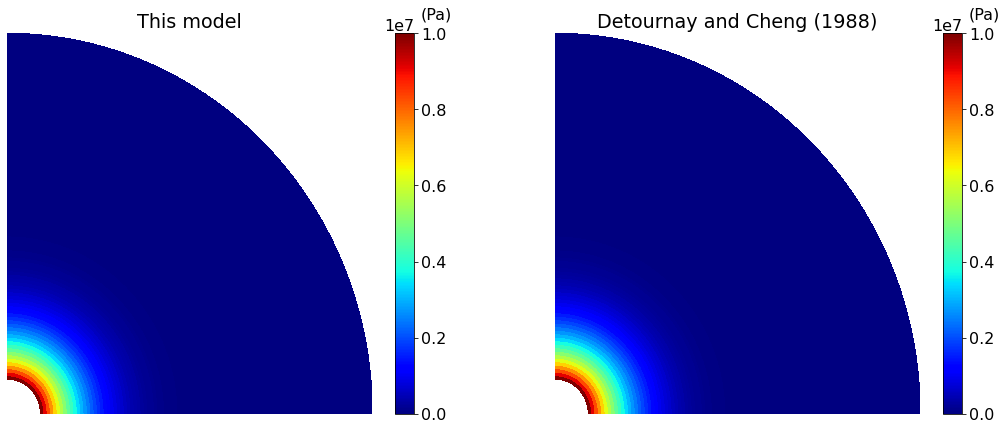

In [12]:

fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, list_p_Laplace[-1], cmap = 'jet', vmin=0, vmax=10e6)
plt.title('This model')
plt.axis('off')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-10, y=1.07, rotation=0)

plt.subplot(122)
plt.pcolor(x, y, list_p_anal[-1], cmap = 'jet', vmin=0, vmax=10e6)
plt.title('Detournay and Cheng (1988)')
plt.axis('off')
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-10, y=1.07, rotation=0)
plt.show()

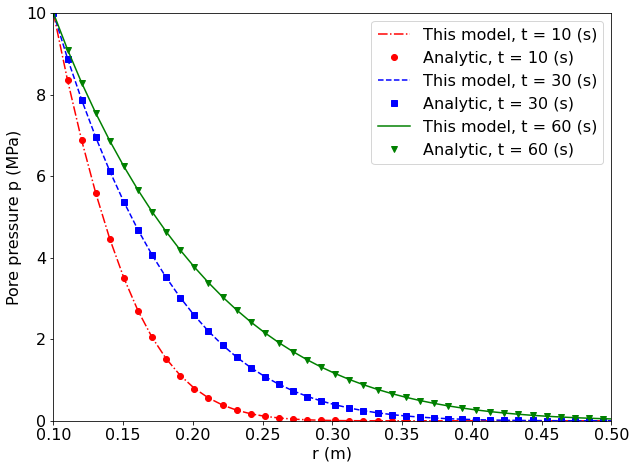

In [13]:
fig = plt.figure(figsize=[10.,7.5])
plt.subplot(111)

list_colors = ['r','b','g']
list_markers = ['o','s','v']
list_line_styles = ['-.', '--','-']

for idx in range(len(list_t)):
    
    p_LFVM = []
    p_ANAL = []
    r_coords = []

    for i in range(0, nx):
        p_LFVM.append(list_p_Laplace[idx][i][0]/1e6)
        p_ANAL.append(list_p_anal[idx][i][0]/1e6)
        r_coords.append(x[i][0])


    plt.plot(r_coords,p_LFVM,linestyle=list_line_styles[idx],color=list_colors[idx],label='This model, t = '+str(list_t[idx])+' (s)')
    plt.plot(r_coords,p_ANAL,list_markers[idx],color=list_colors[idx],label='Analytic, t = '+str(list_t[idx])+' (s)')
plt.xlabel('r (m)')
plt.ylabel('Pore pressure p (MPa)')
plt.xlim(0.1,0.5)
plt.ylim(0,10)
plt.legend()
#plt.title('t = ' + str(t) + ' (s)')
plt.show()

Example 2: Anisotropic case - horizontal well

In [14]:
pIn = 10e6
pOut = 0
r0 = 0.1
Lx = 1.
Ly = 1.

nx = 100
ny = 100
x, y = np.mgrid[0:Lx:nx*1j, 0:Ly:ny*1j]

theta = y/Ly*np.pi/2.
r = r0 + x
x = r*np.cos(theta)
y = r*np.sin(theta)

t = 3600

muf = 1e-3

c_fluid = 5e-10
kappa = 1e-17/muf
phi = 0.1

# Biot's modulus
M = 1./(phi*c_fluid)

# Diffusion coefficient
c = kappa * M


cxx = c*np.ones( (nx,ny) )
cyy = 0.1*cxx

In [15]:
list_p_Laplace = []
list_p_implicit = []
list_t = [10,30,60]

In [16]:
%%time
for t in list_t:
    p_Laplace = Laplace_FVM(pIn,pOut,x,y,nx,ny,cxx,cyy,t,4)
    
    list_p_Laplace.append(p_Laplace.reshape(nx,ny))

CPU times: user 54.4 s, sys: 5 s, total: 59.4 s
Wall time: 54.1 s


In [17]:
%%time
for t in list_t:
    p_implicit = implicit_FVM(pIn,pOut,x,y,nx,ny,cxx,cyy,t,100)
    list_p_implicit.append(p_implicit.reshape(nx,ny))

CPU times: user 11min 18s, sys: 1min 5s, total: 12min 23s
Wall time: 11min 15s


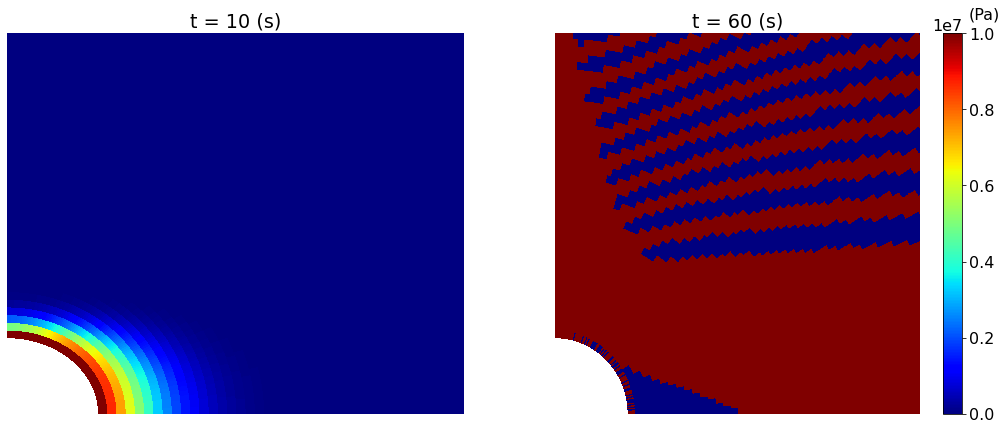

In [18]:
fig = plt.figure(figsize=[18,7])
plt.subplot(121)
plt.pcolor(x, y, list_p_Laplace[0], cmap = 'jet', vmin=0, vmax=10e6)
#plt.title('This model')
plt.axis('off')
plt.xlim(0,5*r0)
plt.ylim(0,5*r0)
#clb = plt.colorbar()
#clb.set_label('(Pa)', labelpad=-10, y=1.07, rotation=0)
plt.title('t = '+str(list_t[0])+' (s)')

plt.subplot(122)
plt.pcolor(x, y, list_p_implicit[0], cmap = 'jet', vmin=0, vmax=10e6)
#plt.title('This model')
plt.axis('off')
plt.xlim(0,5*r0)
plt.ylim(0,5*r0)
clb = plt.colorbar()
clb.set_label('(Pa)', labelpad=-10, y=1.07, rotation=0)
plt.title('t = '+str(list_t[-1])+' (s)')

plt.show()

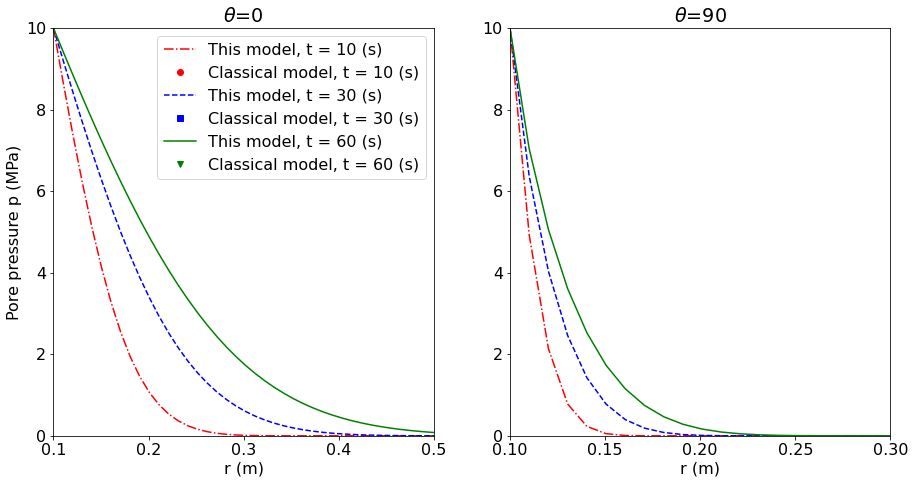

In [19]:
fig = plt.figure(figsize=[15.,7.5])

list_colors = ['r','b','g']
list_markers = ['o','s','v']
list_line_styles = ['-.', '--','-']

plt.subplot(121)
for idx in range(len(list_t)):
    
    p_LFVM = []
    p_implicit = []
    r_coords = []

    for i in range(0, nx):
        p_LFVM.append(list_p_Laplace[idx][i][0]/1e6)
        p_implicit.append(list_p_implicit[idx][i][0]/1e6)
        r_coords.append(x[i][0])


    plt.plot(r_coords,p_LFVM,linestyle=list_line_styles[idx],color=list_colors[idx],label='This model, t = '+str(list_t[idx])+' (s)')
    plt.plot(r_coords,p_implicit,list_markers[idx],color=list_colors[idx],label='Classical model, t = '+str(list_t[idx])+' (s)')
plt.xlabel('r (m)')
plt.ylabel('Pore pressure p (MPa)')
plt.xlim(0.1,0.5)
plt.ylim(0,10)
plt.legend()
plt.title(r'$\theta$=0')

plt.subplot(122)
for idx in range(len(list_t)):
    
    p_LFVM = []
    p_implicit = []
    r_coords = []

    for i in range(0, nx):
        p_LFVM.append(list_p_Laplace[idx][i][-1]/1e6)
        p_implicit.append(list_p_implicit[idx][i][-1]/1e6)
        r_coords.append(y[i][-1])


    plt.plot(r_coords,p_LFVM,linestyle=list_line_styles[idx],color=list_colors[idx],label='This model, t = '+str(list_t[idx])+' (s)')
    plt.plot(r_coords,p_implicit,list_markers[idx],color=list_colors[idx],label='Classical model, t = '+str(list_t[idx])+' (s)')
plt.xlabel('r (m)')
#plt.ylabel('Pore pressure p (MPa)')
plt.xlim(0.1,0.3)
plt.ylim(0,10)
plt.title(r'$\theta$=90')
#plt.legend()

plt.show()

In [20]:
len(r_coords)

100

In [21]:
p_implicit

[2.295970061229771e+23,
 4.710631250312562e+102,
 2.832275562084088e+102,
 9.835621721708898e+101,
 2.5609903022250945e+101,
 5.543382581529864e+100,
 1.0534906189738704e+100,
 1.8173409865307904e+99,
 2.9092340991312737e+98,
 4.389125918723269e+97,
 6.31156867530089e+96,
 8.724527240859041e+95,
 1.1668869673214396e+95,
 1.5178378024572714e+94,
 1.9280137554105375e+93,
 2.3995167996833488e+92,
 2.9339171074646837e+91,
 3.5323298698923052e+90,
 4.195489322938325e+89,
 4.923819217415774e+88,
 5.717500157400328e+87,
 6.576532385388337e+86,
 7.500790327250615e+85,
 8.490065778062064e+84,
 9.544100731369552e+83,
 1.0662615385731402e+83,
 1.1845337125674499e+82,
 1.3092030674563625e+81,
 1.4402522431413966e+80,
 1.5776710805340483e+79,
 1.721456292308126e+78,
 1.8716110673061395e+77,
 2.028146282214644e+76,
 2.1910836250203675e+75,
 2.360458550659643e+74,
 2.5363198671919697e+73,
 2.718724896280715e+72,
 2.9077338439002804e+71,
 3.103410127564194e+70,
 3.3058302325180545e+69,
 3.515097087366